In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # لاستخدامه في Scaled_Sales
import warnings
import os 

In [2]:
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

In [3]:
cleaned_file_path = "E:\Super_Store_Sales\csv_files\Superstore_Sales_Dataset_Cleaned.csv"

In [4]:
output_folder = "E:\Super_Store_Sales\csv_files"
transformed_file_name = "Superstore_Sales_Dataset_Transformed.csv"
transformed_file_path = os.path.join(output_folder, transformed_file_name)
plot_path = "E:\Super_Store_Sales\Plots"

In [5]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"The output folder for the CSV has been created: {output_folder}")

In [6]:
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
    print(f"The output folder for the graphs has been created: {plot_path}")

In [7]:
# Load Cleaned Data
df = pd.read_csv(cleaned_file_path)

In [8]:
# --- Data Transformation & Feature Engineering ---
print("\n" + "="*50)
print("Data Transformation & Feature Engineering")
print("="*50)


Data Transformation & Feature Engineering


In [9]:
# Ensure date columns are datetime objects
print("- Ensure that date columns are in datetime format")
date_cols = ['Order Date', 'Ship Date']
for col in date_cols:
    if col in df.columns:
        # Convert if the type is not already datetime
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
             df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        print(f"  * Warning: Column '{col}' does not exist.")

- Ensure that date columns are in datetime format


In [10]:
# Delete rows that may contain NaT (date conversion failure) if found.
print("- Check and delete rows with date errors (NaT)")
initial_rows = len(df)
df.dropna(subset=date_cols, inplace=True)
rows_dropped = initial_rows - len(df)
if rows_dropped > 0:
    print(f"  * The {rows_dropped} row was dropped due to NaT values ​​in the date columns.")

- Check and delete rows with date errors (NaT)
  * The 7124 row was dropped due to NaT values ​​in the date columns.


In [11]:
# Extract date components from 'Order Date'
print("- Extract date components (Year, Month, Day, Weekday)")
if 'Order Date' in df.columns:
    df['Order_Year'] = df['Order Date'].dt.year
    df['Order_Month'] = df['Order Date'].dt.month
    df['Order_Month_Name'] = df['Order Date'].dt.strftime('%B')
    df['Order_Day'] = df['Order Date'].dt.day
    df['Order_Weekday'] = df['Order Date'].dt.dayofweek 
    df['Order_Weekday_Name'] = df['Order Date'].dt.strftime('%A')
else:
    print("  * Date components cannot be extracted because 'Order Date' is missing.")

- Extract date components (Year, Month, Day, Weekday)


In [12]:
# Calculate shipping delay in days
print("- Shipping_Delay Calculation")
if 'Ship Date' in df.columns and 'Order Date' in df.columns:
    df['Shipping_Delay'] = (df['Ship Date'] - df['Order Date']).dt.days
    # Handle potential negative delays (data error) by making them zero.
    negative_delays = (df['Shipping_Delay'] < 0).sum()
    if negative_delays > 0:
        print(f"  * Warning: A negative delay condition {negative_delays} was found. It will be converted to 0.")
        df['Shipping_Delay'] = df['Shipping_Delay'].clip(lower=0)
else:
     print("  * Shipping delays cannot be calculated due to the lack of a 'Ship Date' or 'Order Date'.")

- Shipping_Delay Calculation


In [13]:
# Calculate Log Sales
print("- Calculate Log_Sales...")
if 'Sales' in df.columns:
    # We use log1p to handle zero and use clip to ensure there are no negative values.
    df['Log_Sales'] = np.log1p(df['Sales'].clip(lower=0))
else:
    print("  * Log_Sales cannot be calculated because there is no 'Sales' column.")

- Calculate Log_Sales...


In [14]:
# Calculating Scaled Sales Using MinMaxScaler
print("- Calculating Scaled_Sales")
if 'Sales' in df.columns:
    scaler = MinMaxScaler()
    # scaler expects a 2D array as input, so we use [['Sales']]
    df['Scaled_Sales'] = scaler.fit_transform(df[['Sales']])
else:
    print("  * Scaled_Sales cannot be calculated because there is no 'Sales' column.")

- Calculating Scaled_Sales


In [15]:
print(f"\Save the transformed and engineered data in: {transformed_file_path}")
try:
    df.to_csv(transformed_file_path, index=False, encoding='utf-8-sig')
    print("The converted file has been saved successfully.")
except Exception as e:
    print(f"An error occurred while saving the converted file: {e}")

\Save the transformed and engineered data in: E:\Super_Store_Sales\csv_files\Superstore_Sales_Dataset_Transformed.csv
The converted file has been saved successfully.


In [16]:
# --- 1. Business Performance Overview (Using Cleaned/Transformed Data) ---
print("\n--- 1. Business Performance Overview ---")


--- 1. Business Performance Overview ---


In [17]:
if 'Sales' in df.columns:
    total_sales = df['Sales'].sum()
    print(f"[PDF Q1] Total Sales: {total_sales:,.2f}")
else:
    print("[PDF Q1] Total sales could not be calculated.")

if 'Order ID' in df.columns:
    total_orders = df['Order ID'].nunique()
    print(f"[PDF Q1] Total Unique Orders: {total_orders}")
    if 'Sales' in df.columns and total_orders > 0:
        avg_order_value = total_sales / total_orders
        print(f"[PDF Q1] Average order value: {avg_order_value:,.2f}")
    else:
        print("[PDF Q1] The average order value cannot be calculated.")
else:
    print("[PDF Q1] The number of unique requests cannot be counted.")

if 'Customer ID' in df.columns:
    total_customers = df['Customer ID'].nunique()
    print(f"[PDF Q1] Total unique customers: {total_customers}")
else:
    print("[PDF Q1] The number of unique customers cannot be counted.")

[PDF Q1] Total Sales: 619,168.22
[PDF Q1] Total Unique Orders: 1332
[PDF Q1] Average order value: 464.84
[PDF Q1] Total unique customers: 665


In [18]:
# Product analysis
if 'Product Name' in df.columns and 'Sales' in df.columns:
    top_products = df.groupby('Product Name')['Sales'].sum().nlargest(10)
    print("[PDF Q2]Top 10 Products by Sales:")
    print(top_products.to_string(float_format='{:,.2f}'.format))

    # Underperforming products (with positive sales)
    bottom_products = df[df['Sales'] > 0].groupby('Product Name')['Sales'].sum().nsmallest(10)
    print("\n[PDF Q4 - Include] Top 10 Products by Sales (Positive Sales):")
    print(bottom_products.to_string(float_format='{:,.2f}'.format))
else:
    print("[PDF Q2/Q4] Product analysis cannot be performed because the required columns are missing.")

if 'Category' in df.columns and 'Sub-Category' in df.columns and 'Sales' in df.columns:
    top_cats = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().nlargest(10)
    print("\n[PDF Q2] Top 10 subcategories by sales:")
    print(top_cats.to_string(float_format='{:,.2f}'.format))

    bottom_cats = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().nsmallest(10)
    print("\n[PDF Q4 - Include] Top 10 Subcategories by Sales:")
    print(bottom_cats.to_string(float_format='{:,.2f}'.format))
else:
     print("[PDF Q2/Q4] The category analysis cannot be performed because the required columns are missing.")

[PDF Q2]Top 10 Products by Sales:
Product Name
Canon imageCLASS 2200 Advanced Copier                           17,499.95
Lexmark MX611dhe Monochrome Laser Printer                       11,219.93
HP Designjet T520 Inkjet Large Format Printer - 24" Color        8,749.95
Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish    8,298.83
Hewlett Packard LaserJet 3310 Copier                             8,159.86
Cubify CubeX 3D Printer Triple Head Print                        7,999.98
Global Deluxe High-Back Manager's Chair                          5,948.38
Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back      5,635.94
GBC DocuBind P400 Electric Binding System                        5,443.96
Bady BDG101FRU Card Printer                                      5,439.93

[PDF Q4 - Include] Top 10 Products by Sales (Positive Sales):
Product Name
Self-Adhesive Ring Binder Labels                                     1.41
Avery Triangle Shaped Sheet Lifters, Black, 2/Pack             

In [19]:
# Geographic performance
if 'State' in df.columns and 'Sales' in df.columns:
    top_states = df.groupby('State')['Sales'].sum().nlargest(10)
    print("[PDF Q3] Top 10 states by sales")
    print(top_states.to_string(float_format='{:,.2f}'.format))

    bottom_states = df.groupby('State')['Sales'].sum().nsmallest(10)
    print("\n[PDF Q3] Top 10 states by sales:")
    print(bottom_states.to_string(float_format='{:,.2f}'.format))
else:
    print("[PDF Q3] The state analysis cannot be performed because the required columns are missing.")

if 'Region' in df.columns and 'Sales' in df.columns:
    region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
    print("\n[PDF Q3] Total sales by region:")
    print(region_sales.to_string(float_format='{:,.2f}'.format))
else:
    print("[PDF Q3] Area analysis cannot be performed because the required columns are missing.")

[PDF Q3] Top 10 states by sales
State
California       117,503.32
New York          91,297.43
Texas             59,858.43
Washington        33,278.65
Virginia          26,156.82
North Carolina    25,788.63
Indiana           24,465.53
Pennsylvania      23,058.46
Florida           20,718.50
Michigan          18,245.24

[PDF Q3] Top 10 states by sales:
State
District of Columbia      33.92
Kansas                   175.07
Louisiana                613.35
Maine                    617.12
West Virginia            673.34
Idaho                    806.78
Iowa                     874.20
New Mexico             1,003.06
South Carolina         1,384.18
Alabama                1,459.51

[PDF Q3] Total sales by region:
Region
West      180,921.24
East      177,009.47
Central   147,409.97
South     113,827.54


[PDF Q4] Monthly Sales Trend Data (Sample):
   Order_Year  Order_Month      Sales  YearMonth
0        2015            1  19546.163 2015-01-01
1        2015            2  11678.994 2015-02-01
2        2015            3   6716.044 2015-03-01
3        2015            4  12455.482 2015-04-01
4        2015            5  15165.051 2015-05-01
The monthly trend chart is saved in: E:\Super_Store_Sales\Plots\monthly_sales_trend.png


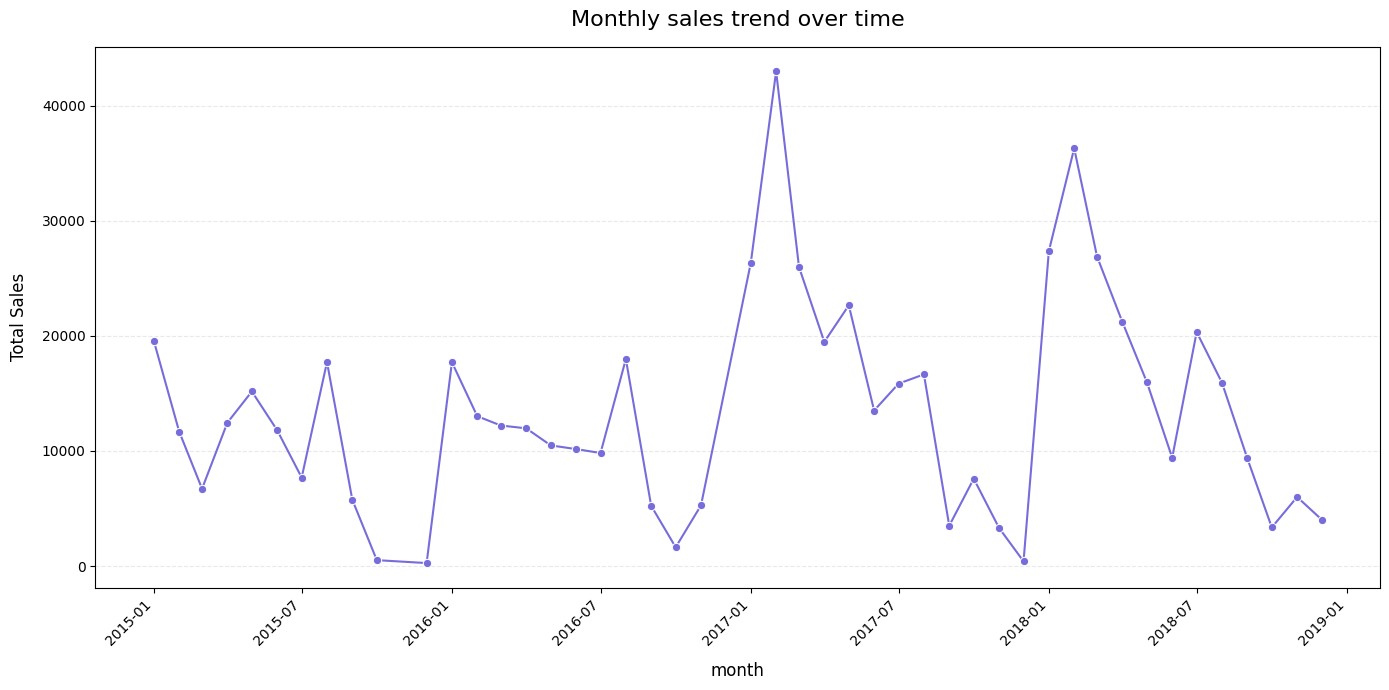


[PDF Q4] Total sales per month (aggregated across years):
Order_Month_Name
January      90,957.98
February    103,951.16
March        71,788.69
April        65,094.95
May          64,277.08
June         44,884.52
July         53,686.42
August       68,279.67
September    23,855.91
October      13,095.97
November     14,585.23
December      4,710.64


In [20]:
# Temporal analysis
if 'Order_Year' in df.columns and 'Order_Month' in df.columns and 'Sales' in df.columns:
    # Monthly sales trend
    monthly_sales = df.groupby(['Order_Year', 'Order_Month'])['Sales'].sum().reset_index()
    monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['Order_Year'].astype(str) + '-' + monthly_sales['Order_Month'].astype(str))
    print("[PDF Q4] Monthly Sales Trend Data (Sample):")
    print(monthly_sales.head())
    
     # Monthly trend chart
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_sales, x='YearMonth', y='Sales', marker='o', color='#766CDB')
    plt.title('Monthly sales trend over time', fontsize=16, pad=15)
    plt.xlabel('month', fontsize=12, labelpad=10)
    plt.ylabel('Total Sales', fontsize=12, labelpad=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7, color='#E0E0E0')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Save chart
    plt_monthly_sales_path = os.path.join(plot_path, 'monthly_sales_trend.png')
    try:
        plt.savefig(plt_monthly_sales_path)
        print(f"The monthly trend chart is saved in: {plt_monthly_sales_path}")
    except Exception as e:
        print(f"Error saving monthly trend chart: {e}")
    plt.show()
    
    # Highest and lowest selling months (overall)
    if 'Order_Month_Name' in df.columns:
        monthly_sales_agg = df.groupby('Order_Month_Name')['Sales'].sum()
        month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        monthly_sales_agg = monthly_sales_agg.reindex(month_order, fill_value=0)
        print("\n[PDF Q4] Total sales per month (aggregated across years):")
        print(monthly_sales_agg.to_string(float_format='{:,.2f}'.format))
    else:
        print("[PDF Q4] Sales cannot be grouped by month name.")
else:
    print("[PDF Q4] Time analysis cannot be performed because the necessary columns are missing.")

In [21]:
# Customer behavior and shipping
if 'Customer ID' in df.columns and 'Customer Name' in df.columns and 'Sales' in df.columns:
    top_customers = df.groupby(['Customer ID', 'Customer Name'])['Sales'].sum().nlargest(10)
    print("[PDF Q5] Top 10 Clients by Total Sales:")
    print(top_customers.to_string(float_format='{:,.2f}'.format))
else:
    print("[PDF Q5] Top clients cannot be identified.")

if 'Segment' in df.columns and 'Sales' in df.columns and 'Order ID' in df.columns:
    segment_sales = df.groupby('Segment').agg(
        Total_Sales=('Sales', 'sum'),
        Average_Sales=('Sales', 'mean'),
        Order_Count=('Order ID', 'nunique')
    ).sort_values(by='Total_Sales', ascending=False)
    print("\n[PDF Q5] Sales performance by customer segment:")
    print(segment_sales.to_string(float_format='{:,.2f}'.format))
else:
    print("[PDF Q5] Performance cannot be analyzed by customer segment.")

[PDF Q5] Top 10 Clients by Total Sales:
Customer ID  Customer Name  
TC-20980     Tamara Chand      18,437.14
BM-11140     Becky Martin      11,432.84
GT-14635     Grant Thornton     9,351.21
CJ-12010     Caroline Jumper    8,989.49
SE-20110     Sanjit Engle       8,805.04
ME-17320     Maria Etezadi      8,081.15
DR-12940     Daniel Raglin      6,937.87
KF-16285     Karen Ferguson     6,903.05
TS-21370     Todd Sumrall       6,646.04
KD-16270     Karen Daniels      6,317.16

[PDF Q5] Sales performance by customer segment:
             Total_Sales  Average_Sales  Order_Count
Segment                                             
Consumer      290,618.89         209.23          672
Corporate     198,921.44         255.68          412
Home Office   129,627.89         254.67          248



[PDF Q5] Number of times to use charging mode:
Ship Mode
Standard Class    1386
Second Class       525
First Class        524
Same Day           241
Name: count, dtype: int64

[PDF Q5] Charging Mode Performance Summary:
                Average_Shipping_Delay  Average_Sales  Total_Sales  Order_Count
Ship Mode                                                                      
Standard Class                  145.77         232.34   322,023.37          691
First Class                      62.84         219.83   115,188.99          272
Second Class                     97.00         236.79   124,312.39          255
Same Day                          1.96         239.18    57,643.48          114

[PDF Q5] Charge Delay Distribution Chart Again
Delayed shipping fee saved in: E:\Super_Store_Sales\Plots\shipping_delay_distribution.png


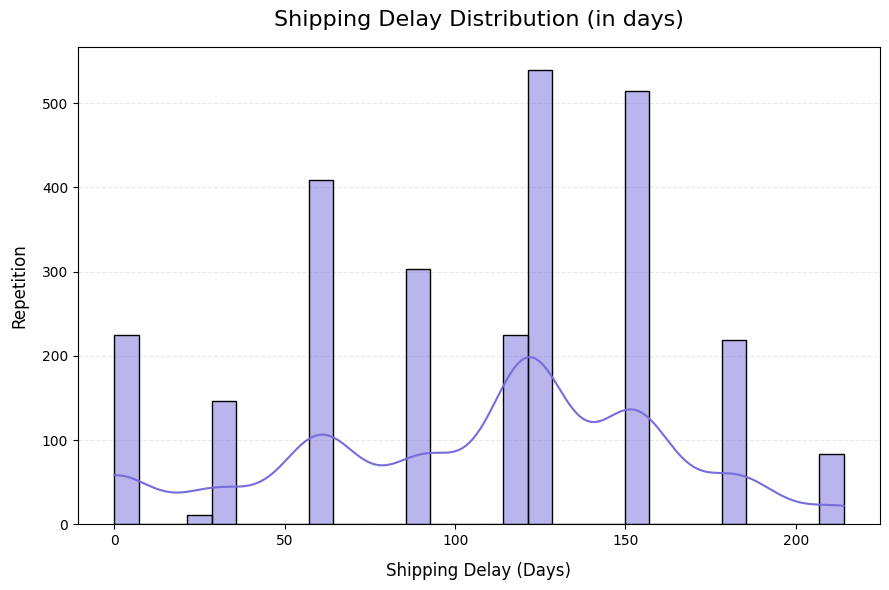

In [22]:
if 'Ship Mode' in df.columns:
    ship_mode_usage = df['Ship Mode'].value_counts()
    print("\n[PDF Q5] Number of times to use charging mode:")
    print(ship_mode_usage)

    if 'Shipping_Delay' in df.columns and 'Sales' in df.columns and 'Order ID' in df.columns:
        ship_mode_performance = df.groupby('Ship Mode').agg(
            Average_Shipping_Delay=('Shipping_Delay', 'mean'),
            Average_Sales=('Sales', 'mean'),
            Total_Sales=('Sales', 'sum'),
            Order_Count=('Order ID', 'nunique')
        ).sort_values(by='Order_Count', ascending=False)
        print("\n[PDF Q5] Charging Mode Performance Summary:")
        print(ship_mode_performance.to_string(float_format='{:,.2f}'.format))

        # Draw the charging delay distribution again for context.
        print("\n[PDF Q5] Charge Delay Distribution Chart Again")
        fig, ax = plt.subplots(figsize=(9, 6))
        sns.histplot(df['Shipping_Delay'], kde=True, color='#766CDB', ax=ax, bins=30)
        ax.set_title('Shipping Delay Distribution (in days)', fontsize=16, pad=15)
        ax.set_xlabel('Shipping Delay (Days)', fontsize=12, labelpad=10)
        ax.set_ylabel('Repetition', fontsize=12, labelpad=10)
        ax.set_axisbelow(True)
        plt.grid(axis='y', linestyle='--', alpha=0.7, color='#E0E0E0')
        plt.tight_layout()
        # Save chart 
        plt_shipping_delay_path = os.path.join(plot_path, 'shipping_delay_distribution.png')
        try:
            plt.savefig(plt_shipping_delay_path)
            print(f"Delayed shipping fee saved in: {plt_shipping_delay_path}")
        except Exception as e:
            print(f"Error saving shipping delay fee: {e}")
        plt.show()
    else:
        print("[PDF Q5] The performance of the charging mode cannot be analyzed due to the lack of necessary columns.")
else:
    print("[PDF Q5] Charging mode usage cannot be analyzed.")